In [1]:
from fastai.vision.all import *
from fastbook import *

path = Path('/home/ilua/fastbook_book14/inteldata/')

In [16]:
# trn_path = path/"train/"
# val_path = path/"valid/"

In [23]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="seg_train",
    valid="seg_test",
    item_tfms=RandomResizedCrop(224, min_scale=0.75),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=128
)

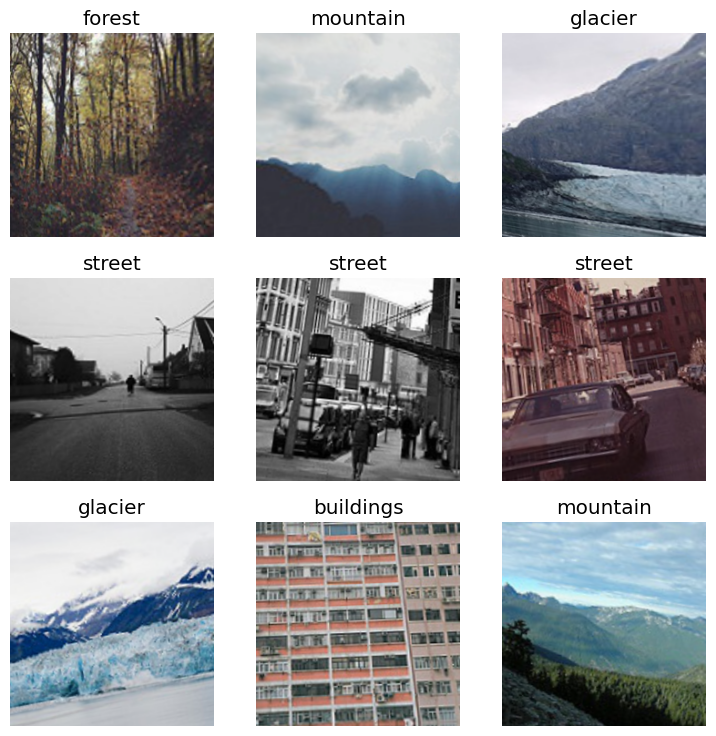

In [28]:
dls.show_batch()

### ResNet baseline

In [25]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 32),
        block(32, 64),
        block(64, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [35]:
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [36]:
learn.fit_one_cycle(8,0.0012)

epoch,train_loss,valid_loss,accuracy,time
0,1.212680,1.027391,0.611000,00:06
1,0.862990,0.771182,0.712667,00:06
2,0.687951,0.640108,0.764333,00:06
3,0.603672,0.626587,0.758000,00:06
4,0.551890,0.477735,0.833000,00:06
5,0.489591,0.441562,0.847000,00:06
6,0.459701,0.432928,0.850667,00:06
7,0.439196,0.415184,0.858000,00:06


### Grabbing test folder

In [29]:
tst_files = get_image_files(path/"seg_pred/seg_pred/")

In [31]:
tst_dl = dls.test_dl(tst_files)

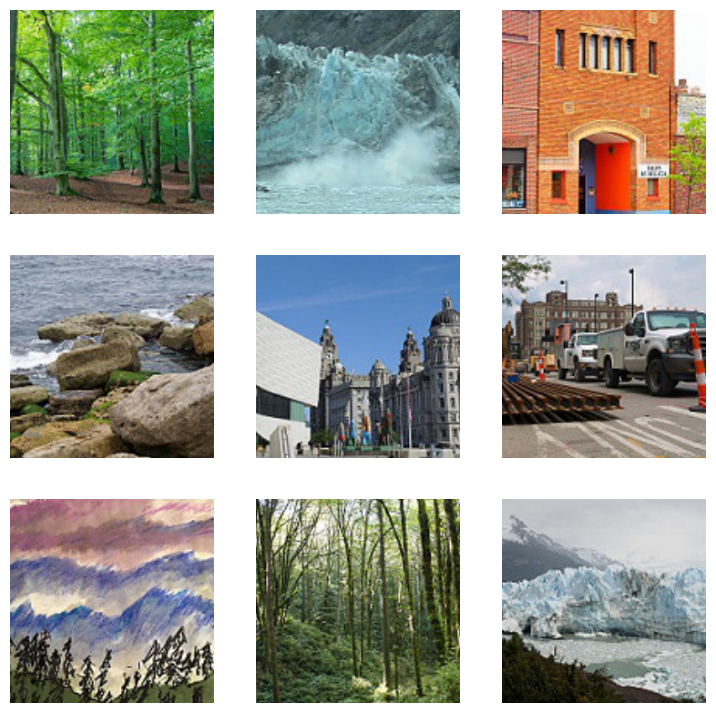

In [32]:
tst_dl.show_batch()

In [37]:
preds = learn.get_preds(dl=tst_dl, with_decoded=True)

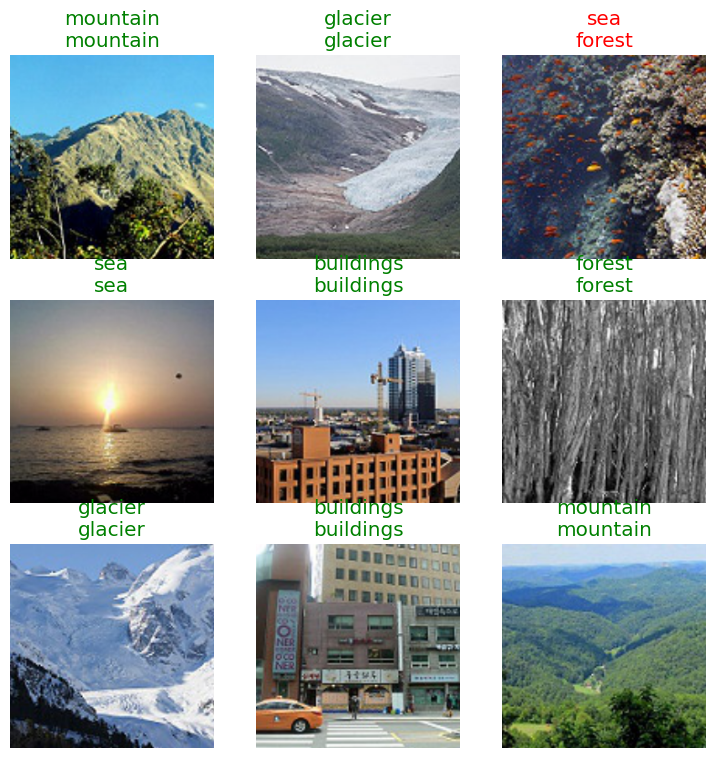

In [39]:
learn.show_results()

### Second try

In [2]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

def block(ni, nf, stride=2):
    return nn.Sequential(ResBlock(ni, nf, stride=stride), ResBlock(nf, nf))

In [52]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="seg_train",
    valid="seg_test",
    item_tfms=RandomResizedCrop(224, min_scale=0.75),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=64
)

def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #37
        block(64, 64), #18
        block(64, 128),  #9
        nn.Dropout(0.15),
        block(128, 256),  #4
        block(256, 256),   
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.15),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [46]:
learn.fit_one_cycle(20,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,1.378240,1.269885,0.516667,00:17
1,1.010201,0.902493,0.657667,00:17
2,0.818004,0.696093,0.739667,00:17
3,0.701244,0.828918,0.701667,00:17
4,0.644188,0.623392,0.769000,00:17
5,0.522398,0.517407,0.815333,00:17
6,0.470547,0.459426,0.836333,00:17
7,0.446062,0.390349,0.859667,00:17
8,0.409264,0.352594,0.870667,00:17
9,0.369120,0.372919,0.864667,00:17


In [7]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="seg_train",
    valid="seg_test",
    item_tfms=RandomResizedCrop(224, min_scale=0.75),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=128
)

def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))
    
def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #37
        block(64, 64), #18
        block(64, 128),  #9
        nn.Dropout(0.15),
        block(128, 256),  #4
        block(256, 256),   
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.15),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [9]:
learn.fit_one_cycle(12,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.289278,0.327307,0.881667,00:14
1,0.317754,0.466628,0.833000,00:13
2,0.349711,0.394685,0.857333,00:14
3,0.330659,0.465648,0.832000,00:14
4,0.326767,0.353922,0.872667,00:14
5,0.297398,0.341590,0.879333,00:13
6,0.276395,0.318677,0.887333,00:13
7,0.253081,0.317372,0.887667,00:13
8,0.224404,0.296024,0.895667,00:14
9,0.201796,0.281766,0.900333,00:14


In [5]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="seg_train",
    valid="seg_test",
    item_tfms=RandomResizedCrop(150, min_scale=0.70),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=256
)

def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))
    
def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #38
        block(64, 64), #19
        block(64, 128),  #10
        nn.Dropout(0.2),
        block(128, 256),  #5
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.2),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [7]:
learn.fit_one_cycle(18, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.727088,0.701176,0.741333,00:07
1,0.722274,0.715447,0.720667,00:07
2,0.697761,0.824446,0.684333,00:07
3,0.681313,0.964312,0.654000,00:07
4,0.638259,0.667693,0.764333,00:07
5,0.594172,0.619932,0.769000,00:07
6,0.544624,0.600198,0.789333,00:07
7,0.510233,0.594874,0.780667,00:07
8,0.480836,0.435770,0.841000,00:07
9,0.442542,0.630940,0.770333,00:07


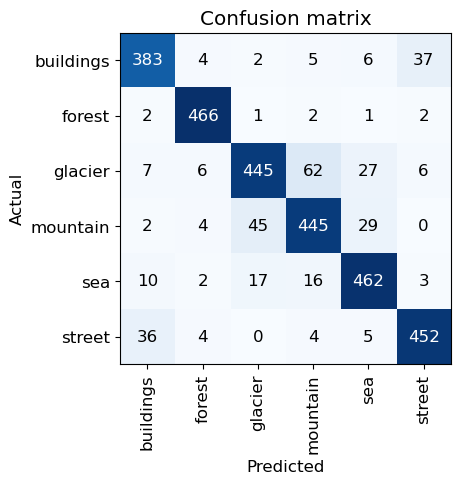

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

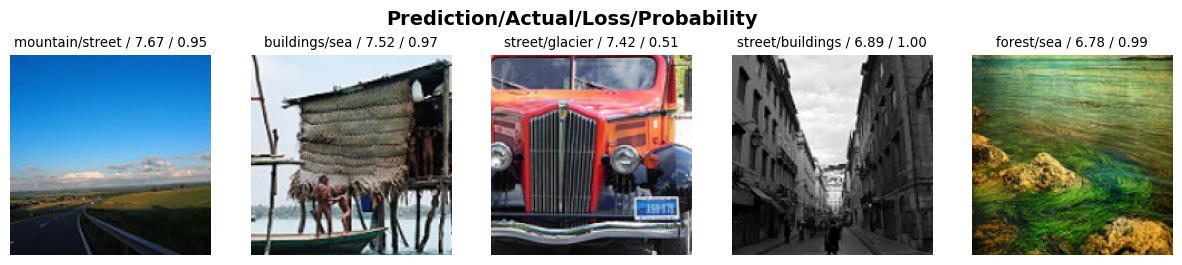

In [12]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(5, nrows=1)